In [1]:

import matplotlib as mpl
mpl.use('Agg')
import os
import h5py
import json
import re
import sys
import datetime
import optparse
import pprint
import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns
from pipeline.python.retinotopy import visualize_rois as vis
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import pandas as pd

from pipeline.python.utils import natural_keys, label_figure, replace_root
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra
from pipeline.python.retinotopy import target_visual_field as targ
from matplotlib.patches import Ellipse


pp = pprint.PrettyPrinter(indent=4)
from scipy.signal import argrelextrema


In [2]:
%matplotlib notebook

In [3]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options

In [4]:
def load_retino_analysis_info(animalid, session, fov, run, retinoid, use_pixels=False, rootdir='/n/coxfs01/2p-data'):
    
    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]
    print("FOV: %s, run: %s" % (fov, run))
    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
        print("Fixed retino id to most recent: %s" % retinoid)
        
    return retinoid, rids[retinoid]


In [5]:
def get_retino_stimulus_info(mwinfo, runinfo):
    
    stiminfo = dict((cond, dict()) for cond in conditions)
    for curr_cond in conditions:
        # get some info from paradigm and run file
        stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stimperiod = 1./stimfreq # sec per cycle
        
        n_frames = runinfo['nvolumes']
        fr = runinfo['frame_rate']
        
        n_cycles = int(round((n_frames/fr) / stimperiod))
        print n_cycles

        n_frames_per_cycle = int(np.floor(stimperiod * fr))
        cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

        stiminfo[curr_cond] = {'stimfreq': stimfreq,
                               'frame_rate': fr,
                               'n_reps': len(trials_by_cond[curr_cond]),
                               'nframes': n_frames,
                               'n_cycles': n_cycles,
                               'n_frames_per_cycle': n_frames_per_cycle,
                               'cycle_start_ixs': cycle_starts
                              }

    return stiminfo

In [6]:
def get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=1):

    
    parsed_traces = dict()
    parsed_cycle_ixs = dict()
    for curr_cond, trial_nums in stiminfo['trials_by_cond'].items():
        ncycles = stiminfo[curr_cond]['n_cycles']
        resampled = ncycles/chunksize
        
        fr_per_cycle = stiminfo[curr_cond]['n_frames_per_cycle'] * chunksize
        cycle_starts = stiminfo[curr_cond]['cycle_start_ixs'][0::chunksize]
        print len(cycle_starts)
        ntrials = len(trials_by_cond[curr_cond])

        roi_cycles = []; cycle_indices = [];
        curr_roi_tracearray = roi_traces[curr_cond]
        for tix in np.arange(0, curr_roi_tracearray.shape[0]):

            roi_trace = curr_roi_tracearray[tix, :] #extr_traces['File%03d' % trial]['processed'][rid, :]

            nparsed_cycles = len(cycle_starts) # ncycles/resampled #chunksize
            ptraces_currtrial = np.zeros((nparsed_cycles, fr_per_cycle))
            cindices_currtrial = np.zeros((nparsed_cycles, chunksize))
            cyc_counter = 0
            for cycle in np.arange(0, nparsed_cycles):
                ixs_to_fill = cycle_starts[cycle] + fr_per_cycle
                if ixs_to_fill > len(roi_trace):
                    roi_trace = np.pad(roi_trace, ((0, ixs_to_fill - len(roi_trace))),\
                                       mode='constant', constant_values=0)
                ptraces_currtrial[cycle, :] = roi_trace[cycle_starts[cycle]:(cycle_starts[cycle]+fr_per_cycle)]
                cindices_currtrial[cycle, :] = stiminfo[curr_cond]['cycle_start_ixs'][cyc_counter:cyc_counter+chunksize]
                cyc_counter += chunksize
                
            roi_cycles.append(ptraces_currtrial)
            cycle_indices.append(cindices_currtrial)
        
        parsed_traces[curr_cond] = np.array(roi_cycles)
        parsed_cycle_ixs[curr_cond] = np.array(cycle_indices) #[s for s in cycle_starts] #[s/chunksize for s in cycle_starts]
        
    return parsed_traces, parsed_cycle_ixs

In [7]:
# Interpolate bar position for found SI frame using upsampled MW tstamps and positions:


def get_interp_positions(condname, mwinfo, stiminfo, trials_by_cond):
    mw_fps = 1./np.diff(np.array(mwinfo[str(trials_by_cond[condname][0])]['stiminfo']['tstamps'])/1E6).mean()
    si_fps = stiminfo[condname]['frame_rate']
    print "[%s]: Downsampling MW positions (sampled at %.2fHz) to SI frame rate (%.2fHz)" % (condname, mw_fps, si_fps)

    si_cyc_ixs = stiminfo[condname]['cycle_start_ixs']
    si_tstamps = runinfo['frame_tstamps_sec']


    #fig, axes = pl.subplots(1, len(trials_by_cond[condname]))

    stim_pos_list = []
    stim_tstamp_list = []

    for ti, trial in enumerate(trials_by_cond[condname]):
        #ax = axes[ti]

        pos_list = []
        tstamp_list = []
        mw_cyc_ixs = mwinfo[str(trial)]['stiminfo']['start_indices']
        for cix in np.arange(0, len(mw_cyc_ixs)):
            if cix==len(mw_cyc_ixs)-1:
                mw_ts = [t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:]]
                xs = mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:]
                si_ts = si_tstamps[si_cyc_ixs[cix]:]
            else:
                mw_ts = np.array([t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]]])
                xs = np.array(mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]])
                si_ts = si_tstamps[si_cyc_ixs[cix]:si_cyc_ixs[cix+1]]

            recentered_mw_ts = [t-mw_ts[0] for t in mw_ts]
            recentered_si_ts = [t-si_ts[0] for t in si_ts]

            # Since MW tstamps are linear, SI tstamps linear, interpolate position values down to SI's lower framerate:
            interpos = sp.interpolate.interp1d(recentered_mw_ts, xs, fill_value='extrapolate')
            resampled_xs = interpos(recentered_si_ts)

            pos_list.append(pd.Series(resampled_xs, name=trial))
            tstamp_list.append(pd.Series(recentered_si_ts, name=trial))

            #ax.plot(recentered_mw_ts, xs, 'ro', alpha=0.5, markersize=2)
            #ax.plot(recentered_si_ts, resampled_xs, 'bx', alpha=0.5, markersize=2)

        pos_vals = pd.concat(pos_list, axis=0).reset_index(drop=True) 
        tstamp_vals = pd.concat(tstamp_list, axis=0).reset_index(drop=True)

        stim_pos_list.append(pos_vals)
        stim_tstamp_list.append(tstamp_vals)

    stim_positions = pd.concat(stim_pos_list, axis=1)
    stim_tstamps = pd.concat(stim_tstamp_list, axis=1)


    return stim_positions, stim_tstamps


In [197]:
def plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs):

    fig, axes = pl.subplots(2,1)

    for axi, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
        ax = axes[axi]

        # Plot FW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c1].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c1][rep,:,:].mean(axis=0), c1_color, lw=0.5)   # Plot each "rep" of chunked cycle
        ax.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), c1_color, label=c1) # Plot average chunked cycle
        ax.legend()
        subcycle_ixs = parsed_cycle_ixs[c1].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs:
            ax.axvline(x=cyc, color='k', lw=0.5)       # Plot cycle start lines

        # Plot BW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c2].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c2][rep,:,:].mean(axis=0), c2_color, lw=0.5)
        ax.plot(parsed_traces[c2].mean(axis=1).mean(axis=0), c2_color, label=c2)
        ax.legend()
        subcycle_ixs = parsed_cycle_ixs[c2].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs: #parsed_cycle_ixs[c2][0:chunksize]:
            ax.axvline(x=cyc, color='k', lw=0.5)
            
    return fig


# Select data set

In [185]:
#options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
options = ['-i', 'JC073', '-S', '20190322', '-R', 'retino_run2', '-A', 'FOV1']

In [186]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Load data

In [187]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)
conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                      for cond in conditions)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print trials_by_cond

# Get stimulus info:
stiminfo = get_retino_stimulus_info(mwinfo, runinfo)
stiminfo['trials_by_cond'] = trials_by_cond

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
extr_traces = h5py.File(extracted_traces_fpath)
print extr_traces.keys()
print extr_traces[extr_traces.keys()[0]].keys()


FOV: FOV1_zoom2p0x, run: retino_run2
Fixed retino id to most recent: analysis002
*** Dataset: JC073|20190322|FOV1|retino_run2|analysis002 ***
Found 12 processed retino runs.
{u'top': [12, 6, 9], u'right': [3, 5, 4], u'left': [11, 1, 8], u'bottom': [10, 2, 7]}
12
12
12
12
[u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']


In [188]:
stiminfo['right']

{'cycle_start_ixs': array([   0,  343,  686, 1029, 1372, 1715, 2058, 2401, 2744, 3087, 3430,
        3773]),
 'frame_rate': 44.6329,
 'n_cycles': 12,
 'n_frames_per_cycle': 343,
 'n_reps': 3,
 'nframes': 4125,
 'stimfreq': 0.13}

# Get bar positions from MW

In [189]:
stim_positions = dict()
stim_tstamps = dict()
for cond in trials_by_cond.keys():
    stim_positions[cond], stim_tstamps[cond] = get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)

#stim_positions1, stim_tstamps1 = get_interp_positions(c1, mwinfo, stiminfo, trials_by_cond)
#stim_positions2, stim_tstamps2 = get_interp_positions(c2, mwinfo, stiminfo, trials_by_cond)

for cond in stim_positions.keys():
    print '%s: [%.2f, %.2f]' %(cond, stim_positions[cond].iloc[0,:].mean(), stim_positions[cond].iloc[-1,:].mean())



[top]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[right]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[left]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[bottom]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
top: [60.69, -65.90]
right: [60.69, -66.05]
bottom: [-60.69, 66.08]
left: [-60.69, 66.07]


# Get FFT results and format

In [190]:
fit, magratio, phase, trials_by_cond = targ.trials_to_dataframes(processed_fpaths, conditions_fpath)
screen_info = visroi.get_screen_info(animalid, session, fov=fov.split('_')[0], interactive=True, rootdir=rootdir)


TRIALS BY COND:
{u'top': [12, 6, 9], u'right': [3, 5, 4], u'left': [11, 1, 8], u'bottom': [10, 2, 7]}
Trials: [11, 10, 12, 1, 3, 2, 5, 4, 7, 6, 9, 8]
1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_data_FOV1_retino_Slice01_Channel01_File005.h5
6: retino_data_FOV1_retino_Slice01_Channel01_File006.h5
7: retino_data_FOV1_retino_Slice01_Channel01_File007.h5
8: retino_data_FOV1_retino_Slice01_Channel01_File008.h5
9: retino_data_FOV1_retino_Slice01_Channel01_File009.h5
10: retino_data_FOV1_retino_Slice01_Channel01_File010.h5
11: retino_data_FOV1_retino_Slice01_Channel01_File011.h5
12: retino_data_FOV1_retino_Slice01_Channel01_File012.h5
Found epi sessions: []
No EPI maps found for session: %s * (trying to use tmp session boundaries file)
('-- getting screen info from:', ['/n/coxfs01/2p-data/JC073/epi_maps/scr

# Convert phsae info to absolute coords

In [191]:

mag_thr = magratio.max(axis=1).max() * 0.3 #0.02
delay_thr = np.pi #/ 2.

absolute_coords = targ.get_absolute_centers(phase, magratio, trials_by_cond, stim_positions, equal_travel_lengths=True,
                                            absolute=True, mag_thr=mag_thr, delay_thr=delay_thr)

('ROIs with best mag-ratio (n=4, thr=0.03):', [104, 188, 189, 194])
[AZ] Average delay (std): 0.26 (1.25)
[EL] Average delay (std): 1.36 (1.17)


In [192]:
[bottom_pos, left_pos, top_pos, right_pos] = absolute_coords['screen_bb']
print "Strongest cells (mag-ratio: %.2f)" % mag_thr, absolute_coords['strong_cells']

Strongest cells (mag-ratio: 0.03) [104, 188, 189, 194]


# Set output dir

In [193]:
output_dir = os.path.join(processed_dir, 'visualization', 'rf_estimates')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get stimulus info

# Parse cycles of each condition

In [194]:
c1 = 'right'
c2 = 'left'
c1_color = 'blue'
c2_color = 'orange'


### Look at 1 ROI first

In [222]:
rid = 189 #absolute_coords['strong_cells'][1]

plot_each_condition = False

roi_traces= dict()
for condition in trials_by_cond.keys():
    roi_traces[condition] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[condition]])
    print"%s:" % condition, roi_traces[condition].shape

if plot_each_condition:
    pl.figure()
    for tr in np.arange(0, roi_traces[c1].shape[0]):
        pl.plot(roi_traces[c1][tr,:], 'k', lw=0.5, alpha=0.5)
    pl.plot(roi_traces[c1].mean(axis=0), 'k', lw=1, alpha=1)
    for cyc in stiminfo[c1]['cycle_start_ixs']:
        pl.axvline(x=cyc, color='r', lw=0.5)

top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


### Get average N cycles

#### Parse roi trace for each trial into N chunks

In [223]:
chunksize = 3
parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=chunksize)
print parsed_traces[c1].shape
print parsed_cycle_ixs[c1].mean(axis=0)

4
4
4
4
(3, 4, 1029)
[[    0.   343.   686.]
 [ 1029.  1372.  1715.]
 [ 2058.  2401.  2744.]
 [ 3087.  3430.  3773.]]


Saving ROI figures to: /n/coxfs01/2p-data/JC073/20190322/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_5c4c97/visualization/rf_estimates/parsed_cycles_by_roi


<IPython.core.display.Javascript object>


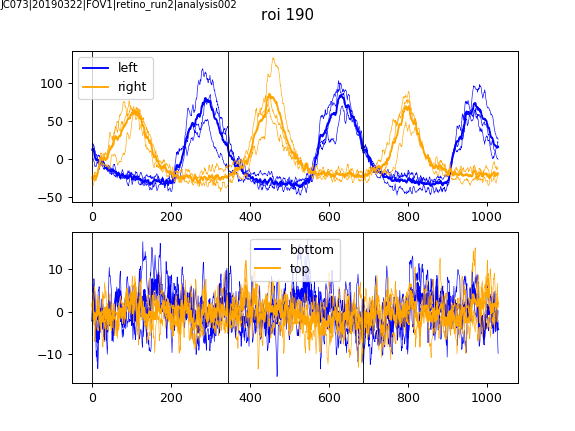

avg_3cycle_by_cond_roi00190


In [224]:
if not os.path.exists(os.path.join(output_dir, 'parsed_cycles_by_roi')):
    os.makedirs(os.path.join(output_dir, 'parsed_cycles_by_roi'))
print "Saving ROI figures to: %s" % os.path.join(output_dir, 'parsed_cycles_by_roi')

subcycle_ixs = stiminfo[c1]['cycle_start_ixs'][0:chunksize]

fig = plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs)
pl.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)

figname = 'avg_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname


# Identify max, min, and "onset" frame in averaged trace

In [225]:
def get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc, baseline_window_size=10., nstds_above_baseline=1.5):

    # Find peaks for each cycle:
    cmaxima = []
    cminima = []
    onsets = []
    baseline_values= []
    baseline_indices = []
    
    # Get max, min, and "onset" for each cycle in "mini" roi-trace:
    for cyc_ix, cyc_start in enumerate(cycle_starts):

        curr_frames = np.arange(cyc_start, cyc_start+fr_per_cyc)
        curr_values = avg_cycle_c1[curr_frames]
        cmax = int(np.where(curr_values==curr_values.max())[0][0])
        cmaxima.append((curr_frames[cmax], curr_values.max()))

        minval = curr_values[0:cmax].min()
        cmin = int(np.where(curr_values[0:cmax]==minval)[0][0])
        cminima.append((curr_frames[cmin], minval))

        baseline = curr_values[cmin-baseline_window_size:cmin] #+baseline_window_size]
        bindices = curr_frames[cmin-baseline_window_size:cmin] #+baseline_window_size]
        if cmin-baseline_window_size < 0: # include frames from previous "cycle" since likely at very edge
            if cyc_ix == 0:
                # No previous cycle to borrow frames from
                bindices = curr_frames[0:cmin+baseline_window_size]
                baseline = curr_values[0:cmin+baseline_window_size]
            else:
                prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cyc)
                prev_values = avg_cycle_c1[prev_frames]
                nprev = baseline_window_size-cmin
                bindices = curr_frames[0:cmin] #+baseline_window_size]
                bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

                baseline = prev_values[-nprev:]
                baseline = np.append(baseline, curr_values[0:cmin]) #+baseline_window_size])

        thr_value = baseline.std() * nstds_above_baseline #curr_values.max()*0.1
        onset = np.where(np.abs(curr_values[0:cmax]-thr_value)==np.min(np.abs(curr_values[0:cmax]-thr_value)))[0]

        onsets.append((curr_frames[onset], curr_values[onset]))
        baseline_values.append(baseline)
        baseline_indices.append(bindices)
        
    loci = {'maxima': cmaxima,
           'minima': cminima,
           'onsets': onsets,
           'baseline_indices': baseline_indices,
           'baseline_values': baseline_values,
           'nstds_above_baseline': nstds_above_baseline}
        
    return loci #cmaxima, cminima, onsets, (baseline_indices, baseline_values)



In [226]:
def plot_cycle_loci(avg_cycle_c1, cycle_starts, loci, avg_pos_c1=None, label='cond', ax=None, color='k'): #cmax, cmin, onsets, bas_ixs, bas_vals):

    if ax is None:
        fig, ax = pl.subplots(figsize=(6,3)) #pl.figure()

    if avg_pos_c1 is None:
        avg_pos_c1 = np.arange(0, len(avg_cycle_c1))
        
    ax.plot(avg_pos_c1, avg_cycle_c1, color=color, lw=0.5, label=label)
    for cyc in cycle_starts:
        cycle_ix = avg_pos_c1[cyc]
        ax.axvline(x=cycle_ix, color=color, linestyle='--', lw=0.5)

    for c in loci['maxima']:
        c_ix = avg_pos_c1[c[0]] 
        c_val = c[1]
        ax.plot(c_ix, c_val, 'k+', markersize=10)

    for c in loci['minima']: #cmin:
        c_ix = avg_pos_c1[c[0]]
        c_val = c[1]
        if color != 'k':
            ax.plot(c_ix, c_val, 'k.', markersize=10)
        else:
            ax.plot(c_ix, c_val, 'y.', markersize=10)

    for ons in loci['onsets']: #onsets:
        if not ons[0].size:
            continue
        on_ix = avg_pos_c1[ons[0]]
        on_val = ons[1]
        
        if color != 'k':
            ax.plot(on_ix, on_val, 'k*', markersize=10)
        else:
            ax.plot(on_ix, on_val, 'g*',  markersize=10)

    #baseline_ixs = [list(avg_pos_c1).index(bi) for bi in loci['baseline_indices']]
    for bi, bv in zip(loci['baseline_indices'], loci['baseline_values']): #bas_ixs, bas_vals):
        bi_ixs = [avg_pos_c1[b] for b in bi]
        ax.plot(bi_ixs, bv, 'gray')
        
    return ax

In [227]:
loci[c1]['baseline_indices']

[array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64]),
 array([352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
        365, 366, 367, 368, 369, 370, 371, 372, 373]),
 array([746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
        759, 760, 761, 762, 763, 764, 765, 766, 767])]

### Plot averaged mini-trace, with key loci

<IPython.core.display.Javascript object>


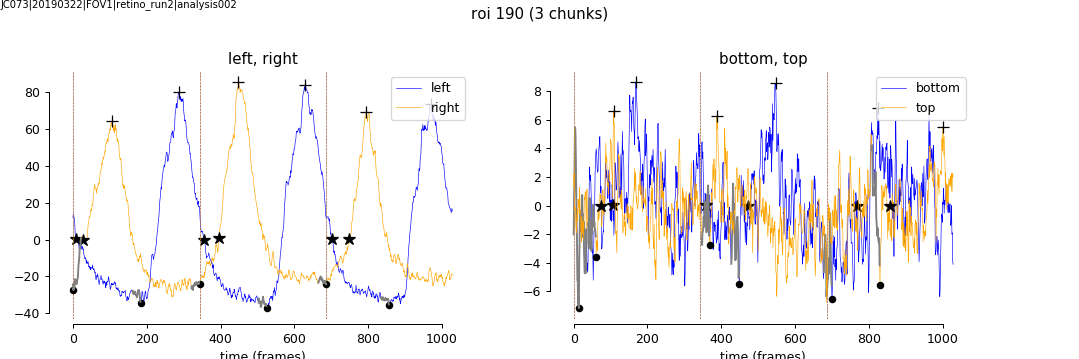

time_v_intensity_cycle_loci_3cycle_by_cond_roi00190


In [228]:
nstds_above_baseline = 0.0
window_nsecs = 0.5

fig, axes = pl.subplots(1, 2, figsize=(12,4)) #pl.figure()

loci = dict()
#for aix, cond in enumerate(trials_by_cond.keys()):
for aix, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
    ax = axes[aix]
    avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
    cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] #[0:chunksize]
    fr_per_cyc = stiminfo[c1]['n_frames_per_cycle'] 
    baseline_window_size = int(round(stiminfo[c1]['frame_rate']*window_nsecs))
    loci[c1] = get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc,
                                                                 baseline_window_size=baseline_window_size, 
                                                                 nstds_above_baseline=nstds_above_baseline)
    ax = plot_cycle_loci(avg_cycle_c1, cycle_starts, loci[c1], ax=ax, label=c1, color=c1_color)

    avg_cycle_c1 = parsed_traces[c2].mean(axis=1).mean(axis=0)
    cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[0,:]] #[0:chunksize]
    fr_per_cyc = stiminfo[c2]['n_frames_per_cycle'] 
    baseline_window_size = int(round(stiminfo[c2]['frame_rate']*window_nsecs))
    loci[c2] = get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc,
                                                                 baseline_window_size=baseline_window_size, 
                                                                 nstds_above_baseline=nstds_above_baseline)
    ax = plot_cycle_loci(avg_cycle_c1, cycle_starts, loci[c2], ax=ax, label=c2, color=c2_color)
    
    ax.set_xlabel('time (frames)')
    ax.legend(loc='upper right')

    ax.set_title('%s, %s' % (c1, c2)) #cond)
    sns.despine(trim=True, offset=4, ax=ax)
    

fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))

pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)

label_figure(fig, data_identifier)


figname = 'time_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname


# Use interp stim positions to get bar position at onset

In [229]:
rf_edges = {}
for (c1, c2) in [('left', 'right'), ('bottom', 'top')]:

    # Use indices of parsed "cycle chunk" (should be nchunks=ncycles/chunksize 'traces' to match position to)
    # ----------------------------------------------------------------------------
    # C1: Average position values to match chunked traces:
    mean_pos_vals1 = stim_positions[c1].mean(axis=1)
    avg_pos_list1 = []
    cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[:, 0]] #[0:chunksize]
    for cix, cyc in enumerate(cycle_starts):
        print cix, cyc
        if cix == len(cycle_starts)-1:
            avg_pos_list1.append(mean_pos_vals1[cyc:])
        else:
            avg_pos_list1.append(mean_pos_vals1[cyc:cycle_starts[cix+1]])
    for ai, a in enumerate(avg_pos_list1):
        avg_pos_list1[ai] = a[0:stiminfo[c1]['n_frames_per_cycle']*chunksize]

    # C2: Average position values to match chunked traces:
    mean_pos_vals2 = stim_positions[c2].mean(axis=1)
    avg_pos_list2 = []
    cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[:, 0]] #[0:chunksize]
    for cix, cyc in enumerate(cycle_starts):
        if cix == len(cycle_starts)-1:
            avg_pos_list2.append(mean_pos_vals2[cyc:])
        else:
            avg_pos_list2.append(mean_pos_vals2[cyc:cycle_starts[cix+1]])
    for ai, a in enumerate(avg_pos_list2):
        avg_pos_list2[ai] = a[0:stiminfo[c2]['n_frames_per_cycle']*chunksize]


    # For each reptition of the "chunked cycle" find corresponding onset position:
    # ----------------------------------------------------------------------------
    onsets1 = loci[c1]['onsets']
    onsets2 = loci[c2]['onsets']

    onset_positions1 = []; peak_positions1 = [];
    onset_positions2 = []; peak_positions2 = [];
    nchunks = len(avg_pos_list1)
    for peak, onset, cyc, bar_pos in zip(loci[c1]['maxima'], onsets1, np.arange(0, nchunks), avg_pos_list1):
        onset_positions1.append(float(bar_pos.iloc[onset[0]]))
        peak_positions1.append(float(bar_pos.iloc[peak[0]]))
        

    nchunks = len(avg_pos_list2)
    for peak, onset, cyc, bar_pos in zip(loci[c2]['maxima'], onsets2, np.arange(0, nchunks), avg_pos_list2):
        onset_positions2.append(float(bar_pos.iloc[onset[0]]))
        peak_positions2.append(float(bar_pos.iloc[peak[0]]))

    onset_pos1 = np.mean(onset_positions1)
    onset_pos2 = np.mean(onset_positions2)

    print "%s: onset %.2f (std %.2f) - peak @ %.2f" % (c1, onset_pos1, np.std(onset_positions1), np.mean(peak_positions1))
    print "%s: onset %.2f (std %.2f) - peak @ %.2f" % (c2, onset_pos2, np.std(onset_positions2), np.mean(peak_positions2))
    

    rf_edges[c1] = {'onset_positions': np.array(onset_positions1),
                    'peak_positions': np.array(peak_positions1),
                   'loci': loci[c1],
                   'nchunks': nchunks,
                   'bar_positions': avg_pos_list1}
    rf_edges[c2] = {'onset_positions': np.array(onset_positions2),
                    'peak_positions': np.array(peak_positions2),
                   'loci': loci[c2],
                   'nchunks': nchunks,
                   'bar_positions': avg_pos_list2}

0 0
1 1029
2 2058
3 3087
left: onset -56.67 (std 1.11) - peak @ 42.39
right: onset 43.88 (std 5.47) - peak @ 22.46
0 0
1 1029
2 2058
3 3087
bottom: onset -22.61 (std 6.93) - peak @ 0.63
top: onset 29.44 (std 23.05) - peak @ 4.40


In [230]:
print "Relative coords?", absolute_coords['used_relative']
print "coords x, y = (%.2f, %.2f)" % (absolute_coords['linX'][rid], absolute_coords['linY'][rid])

Relative coords? False
coords x, y = (27.96, 40.70)


In [231]:
print avg_cycle_c1.shape
print avg_pos_list1[0].shape

(1029,)
(1029,)


<IPython.core.display.Javascript object>


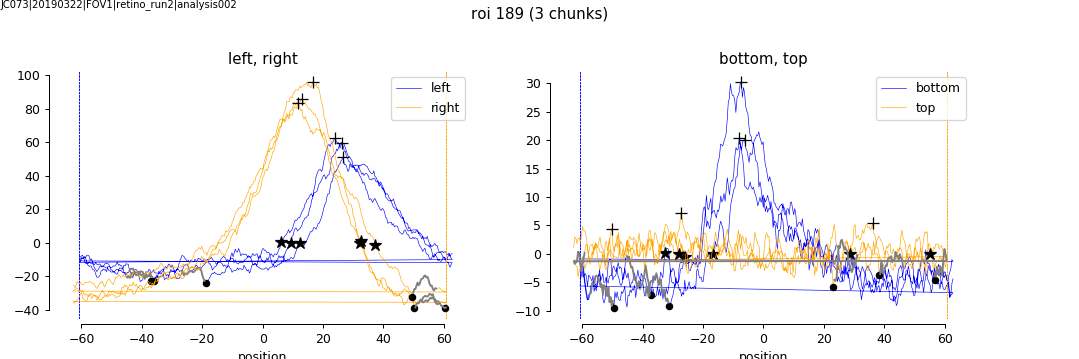

position_v_intensity_cycle_loci_3cycle_by_cond_roi00189


In [214]:
fig, axes = pl.subplots(1, 2, figsize=(12,4)) #pl.figure()

#for aix, cond in enumerate(trials_by_cond.keys()):
for aix, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
    ax = axes[aix]
    avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
    avg_pos_c1 = np.array(rf_edges[c1]['bar_positions']).mean(axis=0)
    cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] #[0:chunksize]
    ax = plot_cycle_loci(avg_cycle_c1, cycle_starts, loci[c1], avg_pos_c1=avg_pos_c1, ax=ax, label=c1, color=c1_color)

    avg_cycle_c2 = parsed_traces[c2].mean(axis=1).mean(axis=0)
    avg_pos_c2 = np.array(rf_edges[c2]['bar_positions']).mean(axis=0)
    cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[0,:]] #[0:chunksize]
    ax = plot_cycle_loci(avg_cycle_c2, cycle_starts, loci[c2], avg_pos_c1=avg_pos_c2, ax=ax, label=c2, color=c2_color)


    ax.set_xlabel('position')
    ax.legend(loc='upper right')

    ax.set_title('%s, %s' % (c1, c2)) #cond)
    sns.despine(trim=True, offset=4, ax=ax)
    

fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))

pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)

label_figure(fig, data_identifier)

figname = 'position_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname

In [129]:
print c1, "start"
print stim_positions[c1].head()

print c1, "tail"
print stim_positions[c1].tail()

bottom start
          12         3          9 
0 -43.715256 -43.715256 -43.715256
1 -43.490689 -43.483236 -43.454793
2 -43.213669 -43.219660 -43.190116
3 -42.959133 -42.945231 -42.926647
4 -42.682948 -42.685739 -42.653413
bottom tail
             12         3          9 
4120  48.963118  48.836303  48.845018
4121  49.238703  49.095523  49.106093
4122  49.514288  49.354742  49.367168
4123  49.789873  49.613962  49.628244
4124  50.065459  49.873182  49.889320


In [215]:
print c2, "start"
print stim_positions[c2].head()

print c2, "tail"
print stim_positions[c2].tail()

top start
          12         6          9 
0  60.690170  60.690170  60.690170
1  60.348413  60.504343  60.524609
2  59.976489  60.136707  60.166182
3  59.611166  59.790984  59.812328
4  59.262324  59.419167  59.446999
top tail
             12         6          9 
4120 -64.615522 -64.487443 -64.441052
4121 -64.975140 -64.833487 -64.777535
4122 -65.334758 -65.179531 -65.114019
4123 -65.694376 -65.525575 -65.450502
4124 -66.053993 -65.871618 -65.786985


# Use calculated edges of RF to draw ellipse

In [216]:
absolute_coords['linX'].max()

56.502170724868506

In [217]:
absolute_coords['linY'].min()

-59.310101006743906

In [218]:
print rid
xpos = absolute_coords['linX'][rid]
ypos = absolute_coords['linY'][rid]
print "x-pos, y-pos: (%.2f, %.2f)" % (xpos, ypos)

right_edge = rf_edges['right']['onset_positions'].mean()
left_edge = rf_edges['left']['onset_positions'].mean()
top_edge = rf_edges['top']['onset_positions'].mean()
bottom_edge = rf_edges['bottom']['onset_positions'].mean()
print "Left/Right edges: [%.2f, %.2f]" % (left_edge, right_edge)
print "Bottom/Top edges: [%.2f, %.2f]" % (bottom_edge, top_edge)


188
x-pos, y-pos: (41.43, -46.11)
Left/Right edges: [9.17, 34.01]
Bottom/Top edges: [-25.13, 18.73]


In [221]:
print rf_edges['top']['onset_positions']

[ 28.68323718 -27.77524306  55.27417139]


In [219]:
# ells = [Ellipse(xy=[linX[ri], linY[ri]], width=az_rfs[ri], height=el_rfs[ri]) for ri in range(nrois)
#                 if az_rfs[ri] > 0 and el_rfs[ri] > 0]

xpos = left_edge + (right_edge - left_edge)/2 #absolute_coords['linX'][rid]
ypos = bottom_edge + (top_edge - bottom_edge)/2
ells = [Ellipse(xy=[xpos, ypos], \
                width=right_edge-left_edge,\
                height=top_edge-bottom_edge)]
                                        

<IPython.core.display.Javascript object>


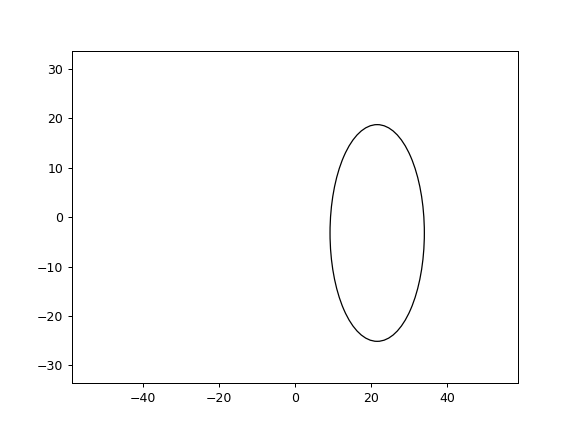

Ellipse(xy=(21.5920058872, -3.20201430795), width=24.8383704549, height=43.8588056235, angle=0.0)


In [220]:
fig, ax = pl.subplots(1)
ax.clear()
#ax.plot(rf_edges['right']['bar_positions'], rf_edges['right']['bar_positions'], alpha=0)
#ax.add_artist(ells)
ax.set_xlim([-screen_info['azimuth']/2, screen_info['azimuth']/2])
ax.set_ylim([-screen_info['elevation']/2, screen_info['elevation']/2])


for ei,e in enumerate(ells): #[0:20]):
    ax.add_artist(e)
    print e
    #e.set_clip_box(ax.bbox)
#        if r2_values[ei] < 0:
#            continue
#        print r2_values[ei]
    #e.set_alpha(r2_values[ei])
    e.set_alpha(1)
    e.set_facecolor('none')
    e.set_linestyle('-')
    e.set_edgecolor('k')